In [1]:
import numpy as np
import pandas as pd

from plotnine import *
import plotnine
plotnine.options.figure_size = (5.2,3.2)

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={"figure.figsize":(16, 8)})

In [3]:
import random

seed = 123
random.seed(seed)
np.random.seed(seed)

In [4]:
regression_acc_df = pd.DataFrame(columns=["Model_name","Score"])
classification_acc_df = pd.DataFrame(columns=["Model_name","Score"])

In [5]:
ass = pd.read_csv('asses.csv')
results = pd.read_csv('results.csv')
courses = pd.read_csv('courses.csv')
reg = pd.read_csv('reg.csv')
info = pd.read_csv('info.csv')
materials = pd.read_csv('materials.csv')
vle = pd.read_csv('vle.csv')

In [6]:
ass['id_assessment'] = ass['id_assessment'].astype(object)

In [7]:
column = ass[(ass['assessment_type'] == 'CMA') & (ass['code_module'] != 'GGG')]['weight']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

column = ass[(ass['assessment_type'] == 'TMA') & (ass['code_module'] != 'GGG')]['weight']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{0.0: 1,
 5.0: 4,
 7.5: 1,
 9.0: 2,
 10.0: 8,
 12.5: 11,
 15.0: 3,
 16.0: 3,
 17.5: 2,
 18.0: 15,
 20.0: 13,
 22.0: 6,
 25.0: 15,
 28.0: 9,
 30.0: 2,
 35.0: 2}

In [8]:
def compareCols(df1, df2):
    df1Columns = df1.columns.values.tolist()
    df2Columns = df2.columns.values.tolist()


    diffDict = set(df1Columns) & set(df2Columns)
    
    print('Shared columns : ', diffDict, '\n')


    diffList = list(diffDict)

    for col in diffList:
        x = df1[col].isin(df2[col]).value_counts()
        print('Check if values are present in both dataframes:')
        print(x, '\n')

def findDiffValues(df1, df2, col):

    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    diff = set(df1_IDs).difference(set(df2_IDs))
    numberDiff = len(diff)

    print("Values from df1 not in df2: " + str(diff))
    print("Number of missing values: " + str(numberDiff))


def printDiffValues(df1, df2, col):

    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    diff = set(df1_IDs).difference(set(df2_IDs))
    
    missingList = list(diff)
    missingDf = df1[df1[col].isin(missingList)]

    return missingDf

printDiffValues(ass, results, 'id_assessment')

ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='TMA'),'weight'] = (100/3)
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='CMA'),'weight'] = (0)

In [9]:
missingList = [30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911]

weight100 = ass[ass['weight'] == 100]
weight100List = weight100['id_assessment'].unique()

compare = set(weight100List).difference(set(missingList))
numberCompare = len(compare)

matchList = [24290, 25354, 24299, 25361, 25368, 25340]

matchDf = ass[ass['id_assessment'].isin(matchList)]

In [10]:
results['id_student'] = results['id_student'].astype(object)
results['id_assessment'] = results['id_assessment'].astype(object)

results.fillna(0, inplace=True)

reg['id_student'] = reg['id_student'].astype(object)

df1_IDs = reg['id_student'].unique()
df2_IDs = info['id_student'].unique()

diff = set(df1_IDs).difference(set(df2_IDs))
numberDiff = len(diff)



In [11]:
info_not_in_results = printDiffValues(info, results, 'id_student')

column = info_not_in_results['final_result']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))
reg_not_in_results = printDiffValues(reg, results, 'id_student')


In [12]:
materials['id_site'] = materials['id_site'].astype(object)

vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)

info['id_student'] = info['id_student'].astype(object)

VLEmaterials = pd.merge(vle, materials, on=['code_module', 'code_presentation', 'id_site'], how='inner')

VLEmaterials.drop(columns=['week_from', 'week_to', 'date'], inplace=True)


In [13]:
total_click_per_student = VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))\
.reset_index()

regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

assResults = pd.merge(ass, results, on=['id_assessment'], how='inner')
assResults = assResults[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked', 'score']]

In [14]:
scores = assResults

scores[scores['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.nunique()

scores['weight*score'] = scores['weight']*scores['score']
sum_scores = scores\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(weightByScore = ('weight*score', sum))\
.reset_index()

total_weight = ass\
.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight', sum))\
.reset_index()

total_weight['total_weight'] = total_weight['total_weight']-100

total_weight.loc[(total_weight.code_module == 'DDD'), 'total_weight'] = 200

score_weights = pd.merge(sum_scores, total_weight, on=['code_module', 'code_presentation'], how='inner')

score_weights['weighted_score'] = score_weights['weightByScore'] / score_weights['total_weight']

score_weights.drop(columns=['weightByScore', 'total_weight'], inplace=True)

In [15]:
lateSubmission = assResults.assign(submission_days=assResults['date_submitted']-assResults['date'])

lateSubmission = lateSubmission.assign(late_submission=lateSubmission['submission_days'] > 0)

In [16]:
lateSubmission[(lateSubmission['assessment_type'] == 'Exam') & (lateSubmission['late_submission'] == True)]

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weight*score,submission_days,late_submission
74900,81351,DDD,2013B,25340,Exam,240.0,248,100.0,0,0.0,0.0,8.0,True
75194,532491,DDD,2013B,25340,Exam,240.0,241,100.0,0,49.0,4900.0,1.0,True
75221,538611,DDD,2013B,25340,Exam,240.0,241,100.0,0,51.0,5100.0,1.0,True
75282,548535,DDD,2013B,25340,Exam,240.0,241,100.0,0,60.0,6000.0,1.0,True
87510,391924,DDD,2014B,25361,Exam,241.0,251,100.0,0,69.0,6900.0,10.0,True
87861,631388,DDD,2014B,25361,Exam,241.0,242,100.0,0,78.0,7800.0,1.0,True
87893,634383,DDD,2014B,25361,Exam,241.0,242,100.0,0,96.0,9600.0,1.0,True


In [17]:
total_late_per_student = lateSubmission\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_late_submission = ('late_submission', sum))\
.reset_index()


In [18]:
total_count_assessments = lateSubmission[['id_student', 'code_module', 'code_presentation', 'id_assessment']]\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.size()\
.reset_index(name='total_assessments')

In [19]:
late_rate_per_student = pd.merge(total_late_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')
late_rate_per_student['late_rate'] = late_rate_per_student['total_late_submission'] / late_rate_per_student['total_assessments']
late_rate_per_student.drop(columns=['total_late_submission', 'total_assessments'], inplace=True)

passRate = assResults
passRate = passRate.assign(fail=passRate['score'] < 40)

In [20]:
total_fails_per_student = passRate\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_fails = ("fail",sum))\
.reset_index()

fail_rate_per_student = pd.merge(total_fails_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')
fail_rate_per_student['fail_rate'] = fail_rate_per_student['total_fails'] / fail_rate_per_student['total_assessments']
fail_rate_per_student.drop(columns=['total_fails', 'total_assessments'], inplace=True)

In [21]:
assessments = pd.merge(score_weights, late_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='inner')
assessments = pd.merge(assessments, fail_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='inner')

merged = pd.merge(regCoursesInfo, total_click_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged = pd.merge(merged, assessments, on=['id_student', 'code_module', 'code_presentation'], how='left')


In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged, test_size=0.3, random_state=42, stratify=merged['code_module'])

In [23]:
train.isnull().sum()

train\
[train['imd_band'].isnull()]\
.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click,weighted_score,late_rate,fail_rate
22165,EEE,2014J,695644,-14.0,NaN,269,M,Ireland,HE Qualification,NaN,35-55,0,60,N,Distinction,3144.0,88.44,0.000000,0.0
27972,FFF,2014J,416407,-43.0,NaN,269,M,North Region,Lower Than A Level,NaN,35-55,1,60,N,Pass,3022.0,80.00,0.083333,0.0
25310,FFF,2013J,589326,-88.0,NaN,268,M,North Region,A Level or Equivalent,NaN,0-35,0,60,N,Distinction,4036.0,96.75,0.000000,0.0
223,AAA,2013J,603861,-38.0,241.0,268,M,North Region,HE Qualification,NaN,55<=,0,60,N,Withdrawn,955.0,64.00,0.600000,0.0
10026,CCC,2014B,623347,-88.0,NaN,241,M,Ireland,Post Graduate Qualification,NaN,0-35,0,90,N,Distinction,694.0,97.32,0.444444,0.0


In [24]:
regions_list = list(train\
                    [train['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    result = train[train['region'] == i].imd_band.mode()
    print(f'{i} IMD band : \n', result)

regions_list = list(train\
                    [train['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    train['imd_band'] = np.where( ( (train['imd_band'].isnull()) & (train['region'] == i) ),
                                           train[train['region'] == i].imd_band.mode(),
                                           train['imd_band']
                                    )


Ireland IMD band : 
 0    0-10%
dtype: object
North Region IMD band : 
 0    10-20
dtype: object
Scotland IMD band : 
 0    50-60%
dtype: object
South Region IMD band : 
 0    90-100%
dtype: object
West Midlands Region IMD band : 
 0    0-10%
dtype: object
Yorkshire Region IMD band : 
 0    0-10%
dtype: object
North Western Region IMD band : 
 0    0-10%
dtype: object
South West Region IMD band : 
 0    30-40%
dtype: object


In [25]:
reg_date_nulls_in_reg = train\
[train['date_registration'].isnull()]

column = reg_date_nulls_in_reg['final_result']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{'Fail': 2, 'Withdrawn': 31}

In [26]:
train['date_registration'] = np.where( (train['date_registration'].isnull()),
                                           train['date_unregistration'] + train.date_registration.median(),
                                           train['date_registration']
                                    )

train['date_registration'] = np.where( (train['date_registration'].isnull()),
                                           train.date_registration.median(),
                                           train['date_registration']
                                    )

train['total_click'] = train['total_click'].replace(np.nan).fillna(0)

train['weighted_score'] = train['weighted_score'].replace(np.nan).fillna(0)

train['late_rate'] = train['late_rate'].replace(np.nan).fillna(1.0)

train['fail_rate'] = train['fail_rate'].replace(np.nan).fillna(1.0)


In [27]:
train_class = train.copy()
test_class = test.copy()

In [28]:
train.drop(columns=['id_student'], inplace=True)
train.drop(columns=['date_unregistration'], inplace=True)
train.drop(columns=['final_result'], inplace=True)

train_class.drop(columns=['id_student'], inplace=True)
train_class.drop(columns=['date_unregistration'], inplace=True)
train_class.drop(columns=['fail_rate'], inplace=True)
train_class.drop(columns=['weighted_score'], inplace=True)
train_class.drop(columns=['late_rate'], inplace=True)


In [29]:
regions_list = list(test\
                    [test['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    test['imd_band'] = np.where( ( (test['imd_band'].isnull()) & (test['region'] == i) ),
                                           test[test['region'] == i].imd_band.mode(),
                                           test['imd_band']
                                    )


reg_date_median = test.date_registration.median()

test['date_registration'] = np.where( (test['date_registration'].isnull()),
                                           test['date_unregistration'] + reg_date_median,
                                           test['date_registration']
                                    )

test['date_registration'] = np.where( (test['date_registration'].isnull()),
                                           reg_date_median,
                                           test['date_registration']
                                    )

test['total_click'] = test['total_click'].replace(np.nan).fillna(0)
test['weighted_score'] = test['weighted_score'].replace(np.nan).fillna(0)
test['late_rate'] = test['late_rate'].replace(np.nan).fillna(1.0)
test['fail_rate'] = test['fail_rate'].replace(np.nan).fillna(1.0)

test.drop(columns=['id_student'], inplace=True)
test.drop(columns=['final_result'], inplace=True)
test.drop(columns=['date_unregistration'], inplace=True)

regions_list = list(test_class\
                    [test_class['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    test_class['imd_band'] = np.where( ( (test_class['imd_band'].isnull()) & (test_class['region'] == i) ),
                                           test_class[test_class['region'] == i].imd_band.mode(),
                                           test_class['imd_band']
                                    )

reg_date_median = test_class.date_registration.median()


test_class['date_registration'] = np.where( (test_class['date_registration'].isnull()),
                                           test_class['date_unregistration'] + reg_date_median,
                                           test_class['date_registration']
                                    )

test_class['date_registration'] = np.where( (test_class['date_registration'].isnull()),
                                           reg_date_median,
                                           test_class['date_registration']
                                    )


test_class['total_click'] = test_class['total_click'].replace(np.nan).fillna(0)

test_class.drop(columns=['id_student'], inplace=True)
test_class.drop(columns=['date_unregistration'], inplace=True)

test_class.drop(columns=['fail_rate'], inplace=True)
test_class.drop(columns=['weighted_score'], inplace=True)
test_class.drop(columns=['late_rate'], inplace=True)



In [30]:
df_num = train.select_dtypes(include=np.number)

for col in df_num.columns:

    skew = df_num[col].skew()
    mean = df_num[col].mean()
    median = df_num[col].median()
    
    print(f'\tSummary for {col.upper()}')
    print(f'Skewness of {col}\t: {skew}')
    print(f'Mean {col} :\t {mean}')
    print(f'Median {col} :\t {median} \n')

	Summary for DATE_REGISTRATION
Skewness of date_registration	: -1.0253067328448258
Mean date_registration :	 -69.555161078238
Median date_registration :	 -57.0 

	Summary for MODULE_PRESENTATION_LENGTH
Skewness of module_presentation_length	: -0.40023285439754913
Mean module_presentation_length :	 255.97712031558186
Median module_presentation_length :	 262.0 

	Summary for NUM_OF_PREV_ATTEMPTS
Skewness of num_of_prev_attempts	: 3.830780709450953
Mean num_of_prev_attempts :	 0.16234933158010081
Median num_of_prev_attempts :	 0.0 

	Summary for STUDIED_CREDITS
Skewness of studied_credits	: 1.7255054465613164
Mean studied_credits :	 79.74928774928775
Median studied_credits :	 60.0 

	Summary for TOTAL_CLICK
Skewness of total_click	: 2.8769457208109963
Mean total_click :	 1345.8841989918913
Median total_click :	 739.0 

	Summary for WEIGHTED_SCORE
Skewness of weighted_score	: -0.4281611222088722
Mean weighted_score :	 52.35455603038954
Median weighted_score :	 60.5 

	Summary for LATE_RATE

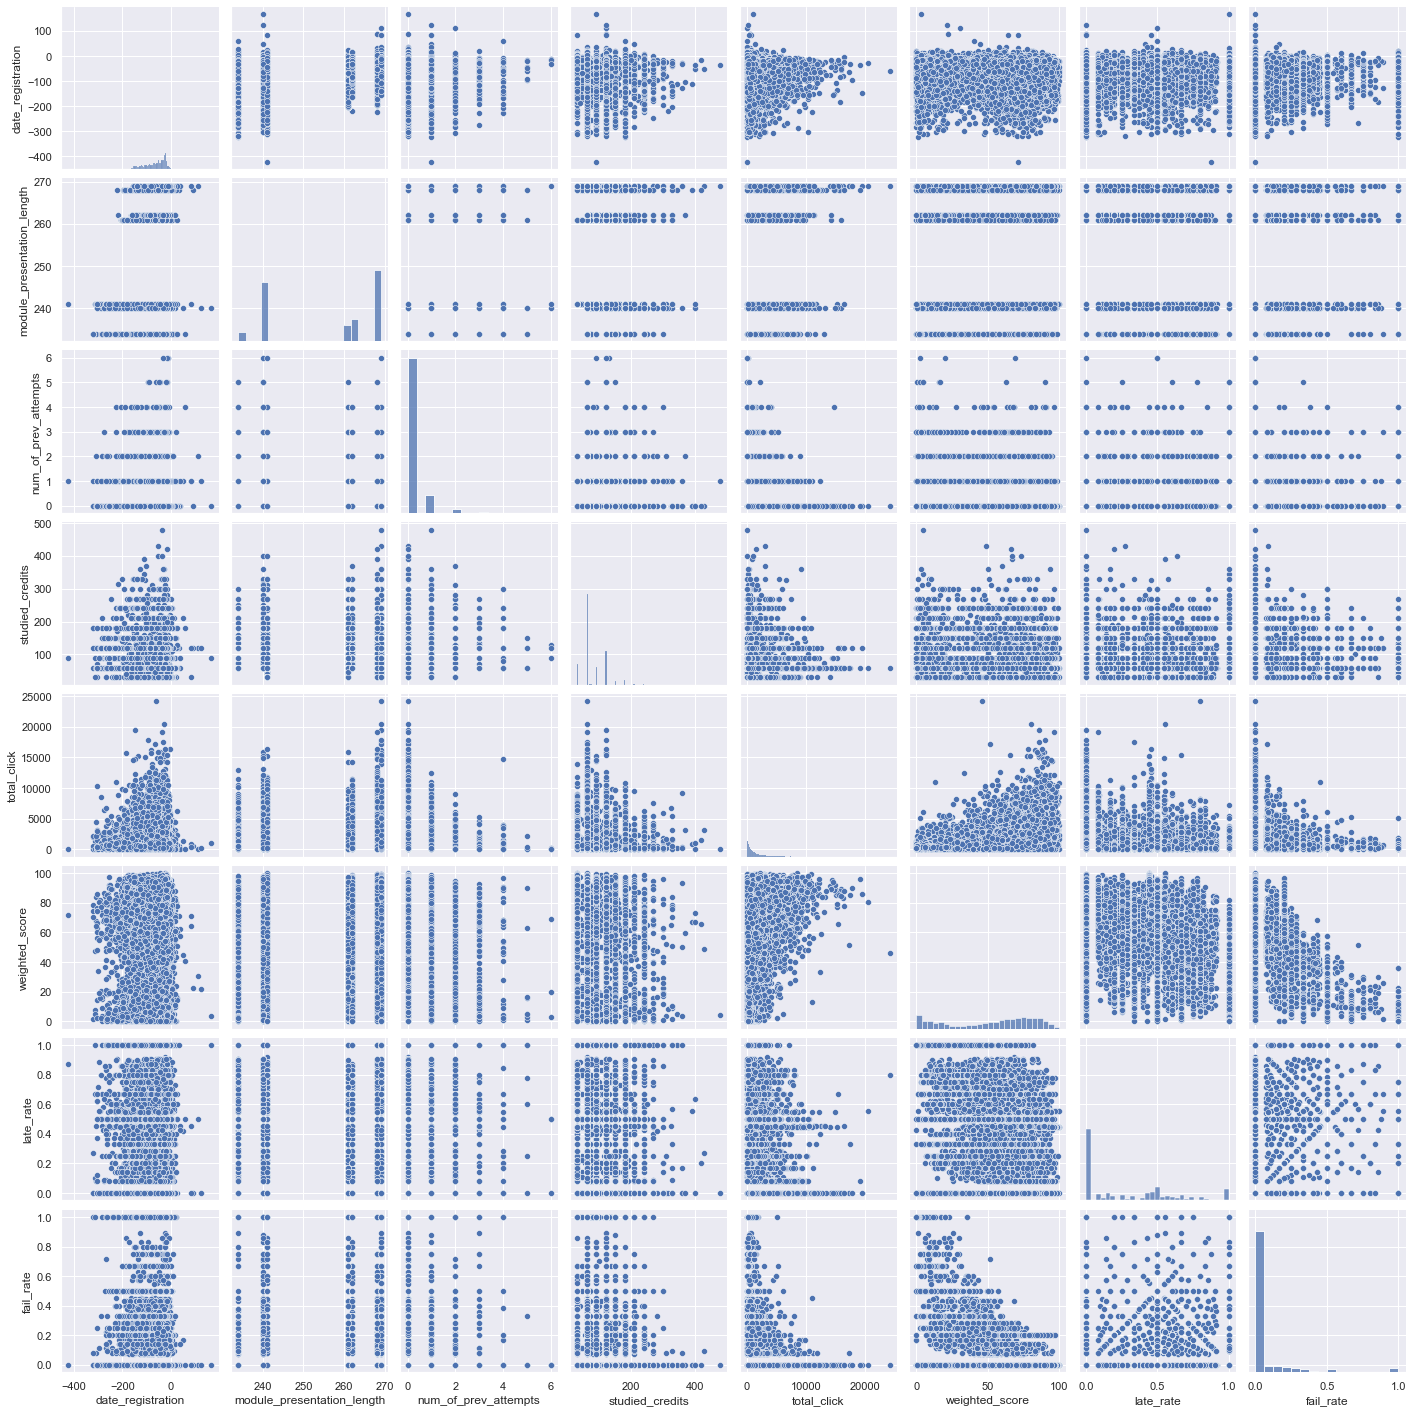

In [31]:
sns.pairplot(train)

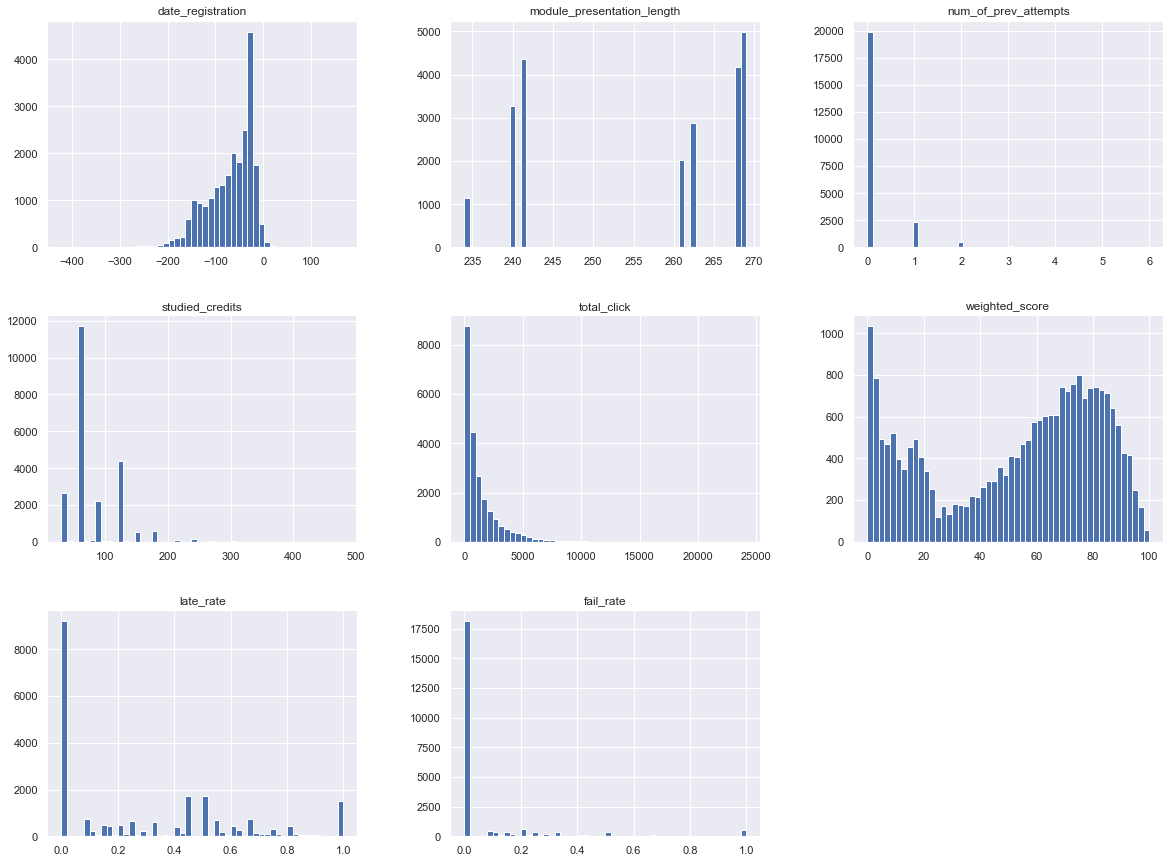

In [32]:
train.hist(bins=50, figsize=(20,15))
plt.show()

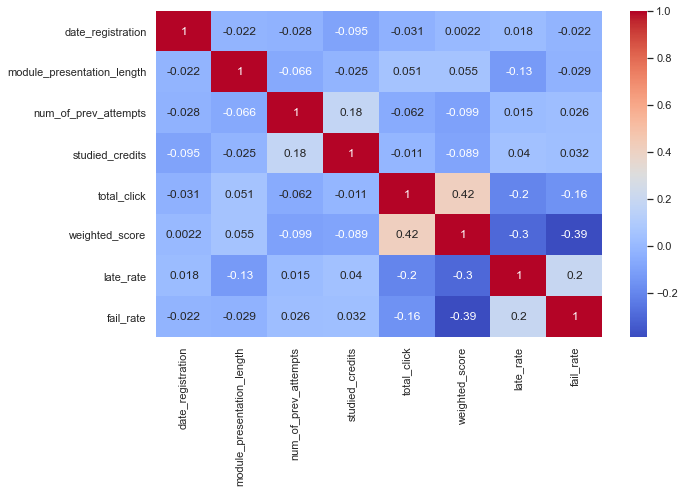

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", );

In [34]:
train['highest_education'] = np.where( (train['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           train['highest_education']
                                    )

train['highest_education'] = np.where( (train['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           train['highest_education']
                                    )


test['highest_education'] = np.where( (test['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           test['highest_education']
                                    )

test['highest_education'] = np.where( (test['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           test['highest_education']
                                    )

train['age_band'] = np.where( (train['age_band'] == '55<='),
                                           '35+',
                                           train['age_band']
                                    )

train['age_band'] = np.where( (train['age_band'] == '35-55'),
                                           '35+',
                                           train['age_band']
                                    )

# Do the same for the test set
test['age_band'] = np.where( (test['age_band'] == '55<='),
                                           '35+',
                                           test['age_band']
                                    )

test['age_band'] = np.where( (test['age_band'] == '35-55'),
                                           '35+',
                                           test['age_band']
                                    )

train = train.assign(fail_final=train['weighted_score'] < 40)

train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,weighted_score,late_rate,fail_rate,fail_final
14921,DDD,2013J,-113.0,261,M,North Western Region,Lower Than A Level,20-30%,0-35,1,60,N,262.0,40.95,0.142857,0.142857,False
27286,FFF,2014B,-66.0,241,M,South Region,Lower Than A Level,50-60%,35+,0,60,N,3775.0,47.50,0.166667,0.083333,False
29880,FFF,2014J,-155.0,269,F,London Region,HE Qualification,10-20,35+,0,60,N,6494.0,35.25,0.250000,0.000000,True
25036,FFF,2013J,-124.0,268,M,South Region,A Level or Equivalent,90-100%,0-35,0,60,N,1996.0,86.00,0.000000,0.000000,False
25661,FFF,2013J,-60.0,268,M,South Region,Lower Than A Level,10-20,0-35,0,60,N,900.0,52.25,0.000000,0.083333,False


In [35]:
X_train = train.drop(columns=['fail_final', 'weighted_score'])

Y_train = train['weighted_score'].copy()

X_test = test.drop(columns=['weighted_score'])
Y_test = test['weighted_score'].copy()

X_train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,late_rate,fail_rate
14921,DDD,2013J,-113.0,261,M,North Western Region,Lower Than A Level,20-30%,0-35,1,60,N,262.0,0.142857,0.142857
27286,FFF,2014B,-66.0,241,M,South Region,Lower Than A Level,50-60%,35+,0,60,N,3775.0,0.166667,0.083333
29880,FFF,2014J,-155.0,269,F,London Region,HE Qualification,10-20,35+,0,60,N,6494.0,0.250000,0.000000
25036,FFF,2013J,-124.0,268,M,South Region,A Level or Equivalent,90-100%,0-35,0,60,N,1996.0,0.000000,0.000000
25661,FFF,2013J,-60.0,268,M,South Region,Lower Than A Level,10-20,0-35,0,60,N,900.0,0.000000,0.083333


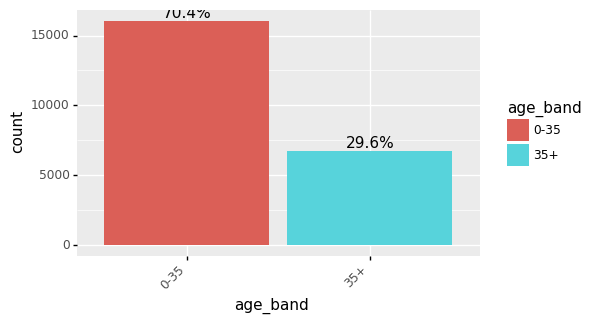

<ggplot: (145495853499)>

In [36]:
(
    ggplot(train)
    + aes(x='age_band', fill='age_band')
    + geom_bar()
    + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

In [37]:
X_train_eval = X_train.copy()
Y_train_eval = Y_train.copy()
X_test_eval = X_test.copy()
Y_test_eval = Y_test.copy()


In [38]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_transformer

In [39]:
column_transform = make_column_transformer(
    (OneHotEncoder(), ['code_module', 'code_presentation', 'gender', 'region', 'age_band', 'disability']),
    (OrdinalEncoder(), ['highest_education', 'imd_band']),
    (RobustScaler(), ['date_registration', 'module_presentation_length',
                       'num_of_prev_attempts', 'studied_credits', 'total_click', 'late_rate',
                       'fail_rate'])
)
X_encoded = column_transform.fit_transform(X_train)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lm = LinearRegression()

lm_pipeline = make_pipeline(column_transform, lm)

lm_pipeline.fit(X_train, Y_train)
lm_train_predictions = lm_pipeline.predict(X_train)

In [41]:
import sklearn.metrics as metrics

def regression_eval(X, y, predictions):
    MSE = metrics.mean_squared_error(y, predictions)
    RMSE = np.sqrt(MSE)
    R2 = metrics.r2_score(y, predictions)
    adj_R2 = 1 - ( (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1) )

    print("-----------------------")
    print('RMSE is {}'.format(RMSE))
    print('Adjusted R2 score is {}\n'.format(adj_R2))

print("Model performance for training set:")
regression_eval(X_train, Y_train, lm_train_predictions)
regression_acc_df.loc[len(regression_acc_df)] = ['Linear_Regression', (metrics.r2_score(Y_train, lm_train_predictions))]

Model performance for training set:
-----------------------
RMSE is 23.917072104963296
Adjusted R2 score is 0.35281050545702963



In [42]:
from sklearn.ensemble import GradientBoostingRegressor

column_transform = make_column_transformer(
    (OneHotEncoder(), ['code_module', 'code_presentation', 'gender', 'region', 'age_band', 'disability']),
    (OrdinalEncoder(), ['highest_education', 'imd_band']),
    remainder='passthrough')
    
GBoost = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1,
                                   max_depth=4, max_features=13,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost_pipeline = make_pipeline(column_transform, GBoost)

GBoost_pipeline.fit(X_train_eval, Y_train_eval)

X_prepared_eval = column_transform.transform(X_test_eval)
test_GBoost_predictions = GBoost.predict(X_prepared_eval)
regression_acc_df.loc[len(regression_acc_df)] = ['GradientBoostingRegressor', (metrics.r2_score(Y_test_eval, test_GBoost_predictions))]
regression_eval(X_test_eval, Y_test_eval, test_GBoost_predictions)

-----------------------
RMSE is 18.045948995664254
Adjusted R2 score is 0.6260658042775316



In [43]:
from sklearn.metrics import r2_score
from sklearn.linear_model import BayesianRidge

model = BayesianRidge()

model_pipeline = make_pipeline(column_transform, model)

model_pipeline.fit(X_train, Y_train)
model_train_predictions = model_pipeline.predict(X_train)
regression_acc_df.loc[len(regression_acc_df)] = ['BayesianRidge', (metrics.r2_score(Y_train, model_train_predictions))]
regression_eval(X_train, Y_train, model_train_predictions)

-----------------------
RMSE is 23.916706470347084
Adjusted R2 score is 0.35283029325318016



In [44]:
from sklearn.linear_model import Lasso
las = Lasso(alpha = 0.1)
las_pipeline = make_pipeline(column_transform, las)

las_pipeline.fit(X_train, Y_train)
las_train_predictions = las_pipeline.predict(X_train)
regression_acc_df.loc[len(regression_acc_df)] = ['Lasso', (metrics.r2_score(Y_train, las_train_predictions))]
regression_eval(X_train, Y_train, las_train_predictions)

-----------------------
RMSE is 23.961995992448582
Adjusted R2 score is 0.35037696565920573



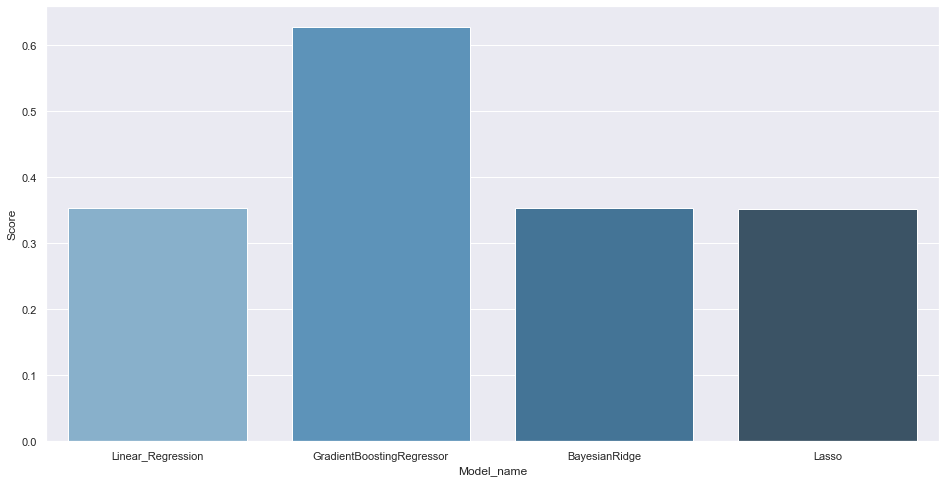

In [45]:
ax = sns.barplot(x="Model_name", y="Score", data=regression_acc_df,
                palette="Blues_d")

In [46]:
train = train_class.copy()
test = test_class.copy()

train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click
14921,DDD,2013J,-113.0,261,M,North Western Region,Lower Than A Level,20-30%,0-35,1,60,N,Fail,262.0
27286,FFF,2014B,-66.0,241,M,South Region,Lower Than A Level,50-60%,35-55,0,60,N,Fail,3775.0
29880,FFF,2014J,-155.0,269,F,London Region,HE Qualification,10-20,35-55,0,60,N,Fail,6494.0
25036,FFF,2013J,-124.0,268,M,South Region,A Level or Equivalent,90-100%,0-35,0,60,N,Distinction,1996.0
25661,FFF,2013J,-60.0,268,M,South Region,Lower Than A Level,10-20,0-35,0,60,N,Pass,900.0


In [47]:
train['final_result'] = np.where( (train['final_result'] == 'Distinction'),
                                           'Pass',
                                           train['final_result']
                                    )
train['final_result'] = np.where( (train['final_result'] == 'Withdrawn'),
                                           'Fail',
                                           train['final_result']
                                    )
test['final_result'] = np.where( (test['final_result'] == 'Distinction'),
                                           'Pass',
                                           test['final_result']
                                    )
test['final_result'] = np.where( (test['final_result'] == 'Withdrawn'),
                                           'Fail',
                                           test['final_result']
                                    )

In [48]:
train['highest_education'] = np.where( (train['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           train['highest_education']
                                    )

train['highest_education'] = np.where( (train['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           train['highest_education']
                                    )


test['highest_education'] = np.where( (test['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           test['highest_education']
                                    )

test['highest_education'] = np.where( (test['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           test['highest_education']
                                    )

train['age_band'] = np.where( (train['age_band'] == '55<='),
                                           '35-55',
                                           train['age_band']
                                    )

train['age_band'] = np.where( (train['age_band'] == '35-55'),
                                           '35+',
                                           train['age_band']
                                    )

test['age_band'] = np.where( (test['age_band'] == '55<='),
                                           '35-55',
                                           test['age_band']
                                    )

test['age_band'] = np.where( (test['age_band'] == '35-55'),
                                           '35+',
                                           test['age_band']
                                    )



In [49]:
X_train = train.drop(columns=['final_result'])

Y_train = train['final_result'].copy()

X_test = test.drop(columns=['final_result'])

Y_test = test['final_result'].copy()

X_train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click
14921,DDD,2013J,-113.0,261,M,North Western Region,Lower Than A Level,20-30%,0-35,1,60,N,262.0
27286,FFF,2014B,-66.0,241,M,South Region,Lower Than A Level,50-60%,35+,0,60,N,3775.0
29880,FFF,2014J,-155.0,269,F,London Region,HE Qualification,10-20,35+,0,60,N,6494.0
25036,FFF,2013J,-124.0,268,M,South Region,A Level or Equivalent,90-100%,0-35,0,60,N,1996.0
25661,FFF,2013J,-60.0,268,M,South Region,Lower Than A Level,10-20,0-35,0,60,N,900.0


In [50]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_transformer

column_transform = make_column_transformer(
    (OneHotEncoder(), ['code_module', 'code_presentation', 'gender', 'region', 'disability']),
    (OrdinalEncoder(), ['highest_education', 'imd_band', 'age_band']),
    remainder='passthrough'
)

X_encoded = column_transform.fit_transform(X_train)


In [51]:
column_transform = make_column_transformer(
    (OneHotEncoder(), ['code_module', 'code_presentation', 'gender', 'region', 'disability']),
    (OrdinalEncoder(), ['highest_education', 'imd_band', 'age_band']),
    (RobustScaler(), ['date_registration', 'module_presentation_length',
                       'num_of_prev_attempts', 'studied_credits', 'total_click'])
)

In [52]:
from sklearn.svm import SVC

SVClass = SVC(kernel='rbf', gamma='auto', degree=2, C = 1,verbose=True)

SVClass_pipeline = make_pipeline(column_transform, SVClass)

print('Evaluation of the test set')
SVClass_pipeline.fit(X_train, Y_train)
X_test_prepared = column_transform.transform(X_test)
SVClass_predictions_test = SVClass.predict(X_test_prepared)
classification_acc_df.loc[len(classification_acc_df)] = ['SVC', metrics.accuracy_score(Y_test, SVClass_predictions_test)]
print('Accuracy score:', metrics.accuracy_score(Y_test, SVClass_predictions_test))

Evaluation of the test set
[LibSVM]Accuracy score: 0.775721006340765


In [53]:
from sklearn.linear_model import SGDClassifier

SGDClass = SGDClassifier(max_iter=1000 ,loss="log", penalty="l2",alpha=0.01, verbose=True,early_stopping=True)
SGDClass_pipeline = make_pipeline(column_transform, SGDClass)

print('Evaluation of the test set')
SGDClass_pipeline.fit(X_train, Y_train)
X_test_prepared = column_transform.transform(X_test)
SGDClass_predictions_test = SGDClass.predict(X_test_prepared)
classification_acc_df.loc[len(classification_acc_df)] = ['SGDClassifier', metrics.accuracy_score(Y_test, SGDClass_predictions_test)]
print('Accuracy score:', metrics.accuracy_score(Y_test, SGDClass_predictions_test))

Evaluation of the test set
-- Epoch 1
Norm: 1.67, NNZs: 36, Bias: -0.461342, T: 20533, Avg. loss: 0.603407
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.71, NNZs: 36, Bias: -0.424738, T: 41066, Avg. loss: 0.491731
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.66, NNZs: 36, Bias: -0.422691, T: 61599, Avg. loss: 0.489537
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1.65, NNZs: 36, Bias: -0.407064, T: 82132, Avg. loss: 0.488689
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 1.64, NNZs: 36, Bias: -0.409887, T: 102665, Avg. loss: 0.488319
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 1.66, NNZs: 36, Bias: -0.405932, T: 123198, Avg. loss: 0.488386
Total training time: 0.05 seconds.
Convergence after 6 epochs took 0.05 seconds
Accuracy score: 0.7495397831867457


In [54]:
!pip3 install xgboost
from xgboost import XGBClassifier



In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.fit_transform(Y_test)


In [56]:
model = XGBClassifier(n_estimators=100,eta=0.3,max_depth=6,sub_sample=0.2)
model_pipeline = make_pipeline(column_transform, model)

print('Evaluation of the test set')
model_pipeline.fit(X_train, y_train)
X_test_prepared = column_transform.transform(X_test)
model_predictions_test = model.predict(X_test_prepared)
classification_acc_df.loc[len(classification_acc_df)] = ['XGBClassifier', metrics.accuracy_score(y_test, model_predictions_test)]
print('Accuracy score:', metrics.accuracy_score(y_test, model_predictions_test))


Evaluation of the test set
[05:56:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy score: 0.7858457762323584


In [57]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 3, bootstrap = True, random_state = 18)
rf_pipeline = make_pipeline(column_transform, rf_model)

print('Evaluation of the test set')
rf_pipeline.fit(X_train, Y_train)
X_test_prepared = column_transform.transform(X_test)
rf_prediction_test = rf_model.predict(X_test_prepared)
classification_acc_df.loc[len(classification_acc_df)] = ['rf_model', metrics.accuracy_score(Y_test, rf_prediction_test)]
print('Accuracy score:', metrics.accuracy_score(Y_test, rf_prediction_test))


Evaluation of the test set
Accuracy score: 0.7409490693393332


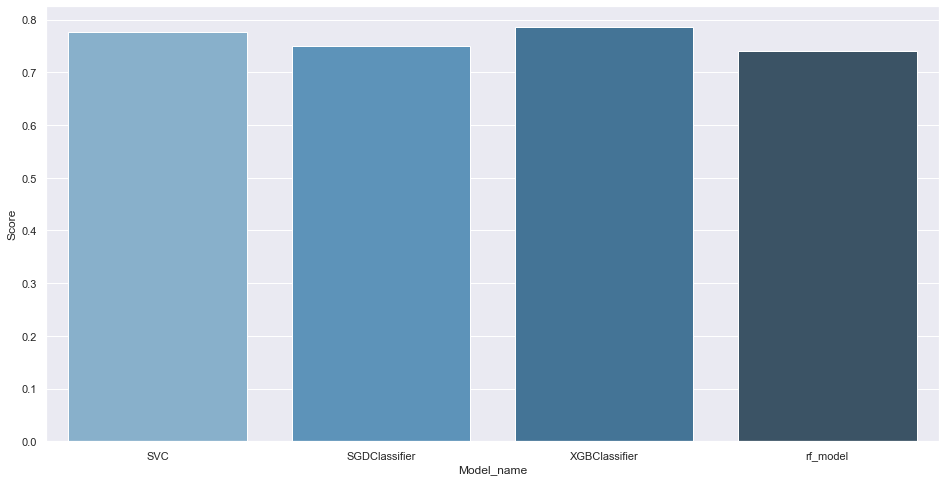

In [58]:
ax = sns.barplot(x="Model_name", y="Score", data=classification_acc_df,
                palette="Blues_d")

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test,model_predictions_test))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5151
           1       0.75      0.82      0.78      4627

    accuracy                           0.79      9778
   macro avg       0.79      0.79      0.79      9778
weighted avg       0.79      0.79      0.79      9778

